In [ ]:

!pip install transformers==4.49.0
!pip install arabert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 94.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 8.0 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=889e54658daf7bd6e1843f169e6d1d310aa2caa4d6c94c1f6f75a2379a8594bb
  Stored in directory: /root/.cache/pip/wheels/94/08/b4/78657b1541bb704b088317b52429ee4016d9888fe47dbb130f
Successfully built emoji


In [ ]:
import torch
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from arabert import ArabertPreprocessor
from arabert.aragpt2.grover.modeling_gpt2 import GPT2LMHeadModel


# Specify the path to data file
data = '/content/dataset10.tsv'

# Read the data file into a Pandas DataFrame

Comments= pd.read_csv(data, sep='\t')


In [ ]:
Comments

,target,text
0,0,على ! الفرق # ان تنتظر للاعوام/% . القادمة
1,0,هل رايت رأفت يوم امس
2,0,الى الامام
3,0,سنة خير ومحبة وسلام
4,0,أسمي آيات التهاني و التبريكات لأسرة نادي الوح...
...,...,...
2372,0,أنت عظيم
2373,0,أنت عبقري
2374,0,أنت زكي
2375,0,أنت مبدع


In [ ]:
Comments.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2377 entries, 0 to 2376
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  2377 non-null   int64 
 1   text    2377 non-null   object
dtypes: int64(1), object(1)
memory usage: 37.3+ KB


In [ ]:
Comments['Letter count']=Comments['text'].apply(len)
Comments

,target,text,Letter count
0,0,على ! الفرق # ان تنتظر للاعوام/% . القادمة,45
1,0,هل رايت رأفت يوم امس,21
2,0,الى الامام,11
3,0,سنة خير ومحبة وسلام,22
4,0,أسمي آيات التهاني و التبريكات لأسرة نادي الوح...,85
...,...,...,...
2372,0,أنت عظيم,14
2373,0,أنت عبقري,15
2374,0,أنت زكي,13
2375,0,أنت مبدع,14


In [ ]:


# Ensure the 'text' and 'target' columns are treated as strings
data = list(zip(Comments['text'].astype(str), Comments['target'].astype(str)))


# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


# Define a custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, target = self.data[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(int(target))  # Assuming target are integers representing the class index
        }



In [ ]:
# Load the BERT tokenizer and model
#tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
#model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)


from transformers import AutoTokenizer, AutoModel

model_name = "aubmindlab/bert-base-arabertv2"

# تحميل التوكنايزر
tokenizer = AutoTokenizer.from_pretrained(model_name)

# تحميل الموديل
model = AutoModelForSequenceClassification.from_pretrained(model_name)



tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# Create datasets and dataloaders
train_dataset = SentimentDataset(train_data, tokenizer)
test_dataset = SentimentDataset(test_data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)



In [ ]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 13

In [ ]:



# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_targets = []

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'target'}
        targets = batch['target'].to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, labels=targets)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Get model predictions
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_targets.extend(targets.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_targets, all_preds)

    # Print loss and accuracy
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Average Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}')


Epoch 1/13: 100%|██████████| 238/238 [40:13<00:00, 10.14s/it]


Epoch 1/13 - Average Loss: 0.3477 - Accuracy: 0.8538


Epoch 2/13:  50%|█████     | 119/238 [19:48<19:42,  9.93s/it]

In [ ]:
# Evaluation
model.eval()
predictions, true_targets = [], []
for batch in tqdm(test_dataloader, desc='Evaluating'):
    inputs = {key: val.to(device) for key, val in batch.items() if key != 'target'}
    targets = batch['target'].to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
    true_targets.extend(targets.cpu().numpy())

Evaluating: 100%|██████████| 60/60 [00:03<00:00, 17.43it/s]


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(true_targets, predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9265


In [ ]:
# Save model locally in Colab
model.save_pretrained('/content/sentimental_analysis_model')
tokenizer.save_pretrained('/content/tokenizer')

('/content/tokenizer/tokenizer_config.json',
 '/content/tokenizer/special_tokens_map.json',
 '/content/tokenizer/vocab.txt',
 '/content/tokenizer/added_tokens.json',
 '/content/tokenizer/tokenizer.json')

In [ ]:
# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(true_targets, predictions)
class_report = classification_report(true_targets, predictions)


In [ ]:
# Display confusion matrix and classification report
print(" AraBertv2")
print(" ----------")

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


 AraBertv2
 ----------
Confusion Matrix:
[[226  26]
 [  9 215]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       252
           1       0.89      0.96      0.92       224

    accuracy                           0.93       476
   macro avg       0.93      0.93      0.93       476
weighted avg       0.93      0.93      0.93       476



In [ ]:

import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
#cleaned="السلام عليكم كيفكن شباب"# Your input text
#cleaned="بخيرالحمد لله"
#cleaned="وعليكم السلام أهلين محمد"


# Tokenize the input text
inputs = tokenizer(cleaned, return_tensors="pt", padding=True, truncation=True, max_length=50)

# Put the model in evaluation mode (so it doesn't update weights)
model.eval()

# Pass the inputs through the model to get the output (logits)
with torch.no_grad():  # Disable gradient computation for inference
    outputs = model(**inputs)

# Get the predicted logits (raw model outputs)
logits = outputs.logits

# Apply a sigmoid to convert the logits to probabilities (if binary classification)
probs = torch.sigmoid(logits)

# Get the first probability (assuming binary classification)
x = probs[0][0].item()

print(x)

# Classify based on the threshold
if x >0.50:
    print("سلبي")
else:
    print("ايجابي")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'cleaned' is not defined

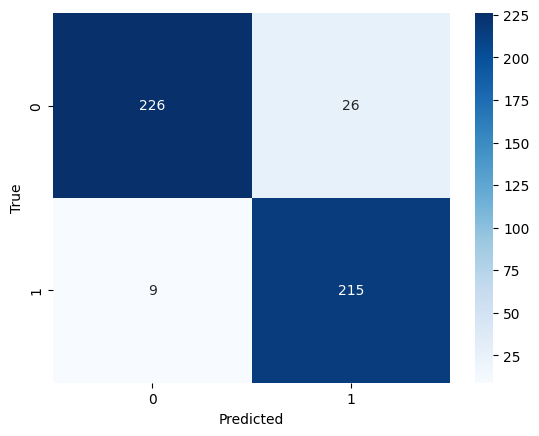

In [ ]:
# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [ ]:
from google.colab import drive

drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:

from transformers import AutoTokenizer, AutoModel

model_name = "aubmindlab/bert-base-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

model.save_pretrained("/content/arabert_model")
tokenizer.save_pretrained("/content/arabert_model")

('/content/arabert_model/tokenizer_config.json',
 '/content/arabert_model/special_tokens_map.json',
 '/content/arabert_model/vocab.txt',
 '/content/arabert_model/added_tokens.json',
 '/content/arabert_model/tokenizer.json')

In [ ]:
%cd /content/sentimental_analysis_model

/content/sentimental_analysis_model


In [ ]:
!zip -r models.zip /content/arabert_part

	zip warning: name not matched: /content/arabert_part

zip error: Nothing to do! (try: zip -r models.zip . -i /content/arabert_part)


In [ ]:
!split -b 100M /content/arabert_model.zip /content/drive/MyDrive/arabert_part


split: cannot open '/content/arabert_model.zip' for reading: No such file or directory


In [ ]:
from google.colab import files
files.download('models.zip')

FileNotFoundError: Cannot find file: models.zip